In [1]:
%matplotlib inline

from functions import *
import statsmodels.api as sm
from scipy.special import logsumexp

In [40]:
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn'])

# Chapter 6: The Haunted DAG & The Causal Terror

(DAG = Directed Acyclic Graph)

Why is it that scientific studies that are newsworthy seem to be not-so trustworthy?

We can artificially create an apparent correlation between newsworthiness and trustworthiness even if the two are completely independent. Imagine that newswortiness and trustworthiness are both equally-weighted selection criteria for grant peer-reviews. A review panel would be more likely to select untrustworthy studies that *would* be newsworthy if true. Similarly, non-newsworthy studies would only be funded if they were trustworthy.

This is called **Berkson's Paradox**, or the *selection-distortion effect*.

Why can't restaurants be in good locations and have good food? Because restaurants with bad food and bad locations go out of business.

[[ 1.         -0.80599031]
 [-0.80599031  1.        ]]


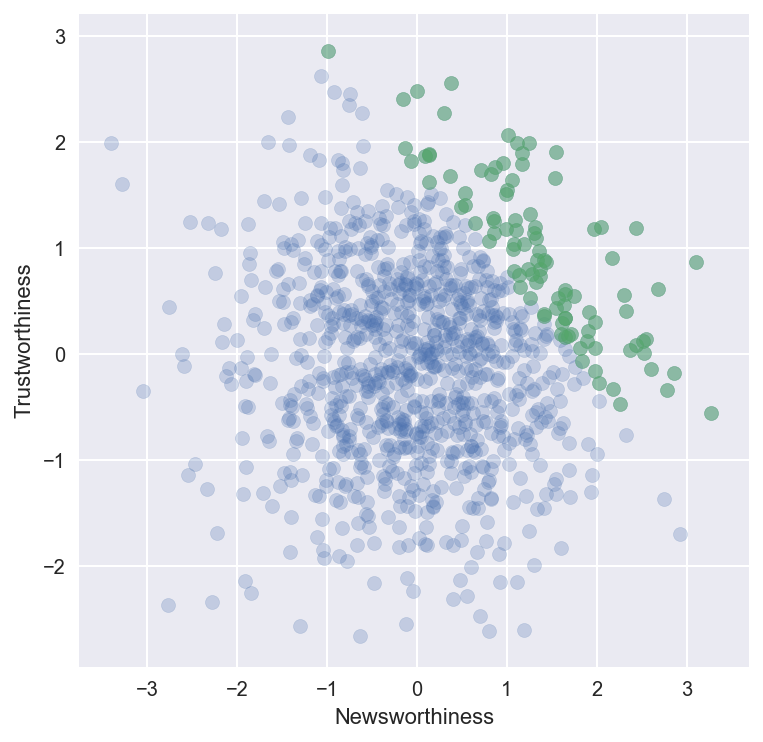

In [41]:
# Simulating selection-distortion
n = 1000    # Number of grant applications
p = 0.1    # Probability of acceptance

# Trustworthiness and newsworthiness (note they are uncorrelated)
tw = pd.Series(np.random.normal(size=n))
nw = pd.Series(np.random.normal(size=n))

# Peer reviewers evaluate the virtues of the grant proposal by adding the scores in each category
score = tw + nw
quantile = np.quantile(score, 1-p)
selected = score >= quantile

# Display results
print(np.corrcoef(tw[selected], nw[selected]))

plt.figure(figsize=(6, 6))
plt.scatter(x=nw, y=tw, alpha = 0.25);
plt.scatter(x=nw[selected], y=tw[selected], alpha = 0.5);
plt.xlabel('Newsworthiness');
plt.ylabel('Trustworthiness');

***

What does this have to do with regression? Unfortunately everything--the selection-distortion effect can happen inside of a multiple regression. 

The act of adding a new variable into the introduces statistical selection within the model (called **collider bias**). 

We may think that we are calculated a model of: `newsworthiness ~ trustworthiness` 

However, we are actually calculating a model of: `newsworthiness ~ trustworthiness | selected`

What we've done is calculated the association of newsworthiness and trustworthiness *conditional* on having been selected by a grant committee.

***

## 6.1 Multicollinearity

(In the previous version of the book this was covered in Chapter 5)

## 6.2 Post-Treatment Bias

(In the previous versino of the book this was covered in Chapter 5)

***

## 6.3 Collider Bias



The first example in the chapter demonstrated that a selection process is all that is necessary for an association between trustworthiness and newsworthiness to be negatively associated.

The same thing can happen inside of a statistical model. This is called **collider bias**.

For example, look at the graph below:

T --> S <-- N

(T) Trustworthiness and (N) Newswortiness influence (S) selection for funding. The fact that both T and N enter S means that S is a collider.

When you condition on a collider, you create a statistical (but not necessarily causal) association among its causes (T and N). Why? Because if we know that a selected proposal has low trustworthiness, then we can infer that it has high newsworthiness. Or that if it has low newsworthiness that it must have high trustworthiness. Otherwise it would not have been selected for funding.


### 6.3.1 Colliderrs of false sorrow

Below is another example of a collider.

We want to study the influence that aging has on happiness. As a well-intentioned scientist, you may decide to "control" for marriage status. It is plausible that marriage could influence happiness, and therefore confound our hypothesis.

However, we may imagine a hypothetical world where:

* Happiness is that it is determined at birth and never changes throughout one's life (this also makes for easier simulation). 

* Happier people are more likely to get married (i.e., your happiness is  proportional to your probability of getting married in a given year).

* The longer you are alive the more likely you will eventually get married (more chances to get married).

If we put together these three variables from our hypothetical world, we get the following graph:

    H --> M <-- A

Happiness (H) and Age (A) both cause marriage (M). Marriage is therefore a collider. Even though we know there is no association between age and happiness in this world, if we incldude marriage in our statistical model we will detect one.



We can create a simulation of this world to prove this point.

(1) Each year, 20 people are born with uniformly distributed happiness

(2) Each year the people age, but their happiness is immutable.

(3) At age 18, individuals can become married, proportional to one's happiness. Once married, individuals remain married.

(4) After age 65, we stop recording data from the individual.

In [3]:
# This is not the exact same way that the book did it, but should still produce similar results.
# Simulate the population. Starting parameters:
pop_per_year = 20
n_years = 200
n = pop_per_year * n_years

df = pd.DataFrame({
    'wave': np.repeat([range(1, n_years + 1)], pop_per_year),
    'age': pd.Series(np.repeat(0, n)),
    'married': pd.Series(np.repeat(0, n)),
    'happiness': pd.Series(np.tile(np.repeat([range(0, 20)], 1), n_years)) # Happiness is on a 20-point scale
})

In [4]:
# Each year do the stuff
for year in range(1, n_years + 1):
    born = df['wave'] <= year
    not_retired = df['age'] < 66
    in_model = born & not_retired

    # for people still in model: update age and marriage status
    df['age'] = df['age'] + 1 * in_model

    # Marriage
    over_17 = df['age'] >= 18
    not_already_married = df['married'] == 0
    marriage_prob = 0.002 + df['happiness'] * 0.002
    married = np.random.binomial(n=1, p=marriage_prob)
    df['married']= df['married'] + (married * in_model * not_already_married * over_17)    # will be 0 if already married, under 18, or over 65
    
df2 = df[(df['age'] < 65) & (df['age'] > 17)]

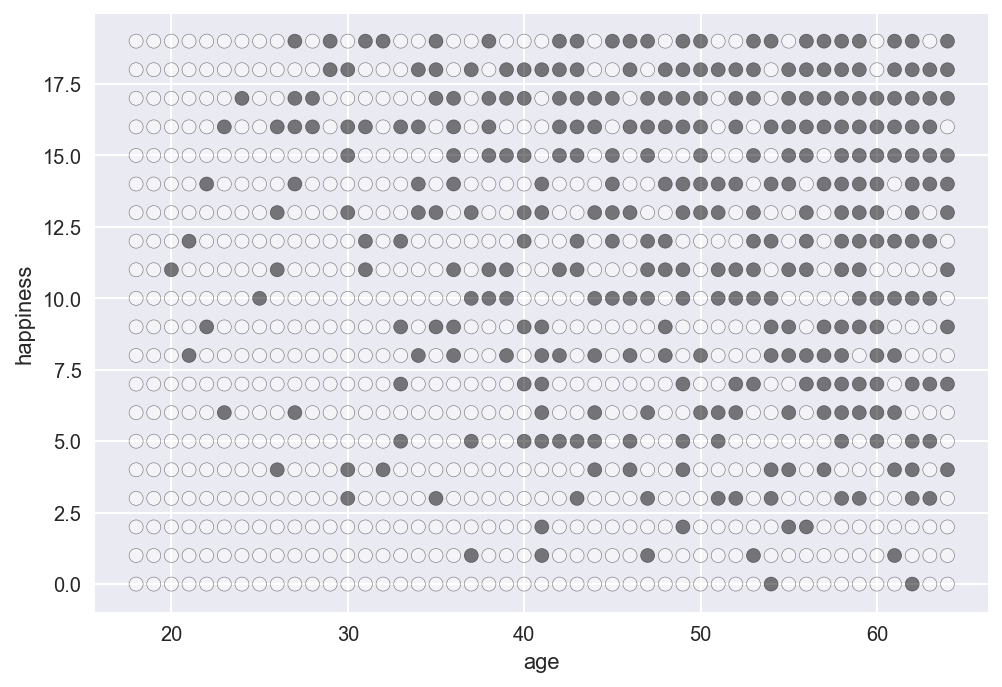

In [42]:
plt.scatter(df2['age'], df2['happiness'], c=df2['married'], edgecolors='black', alpha = 0.5);
plt.xlabel('age');
plt.ylabel('happiness');

In [6]:
#married
print(df2[df2['married'] == 1]['happiness'].describe())
#unmarried
print(df2[df2['married'] == 0]['happiness'].describe())

count    326.000000
mean      11.861963
std        5.093824
min        0.000000
25%        8.000000
50%       13.000000
75%       16.000000
max       19.000000
Name: happiness, dtype: float64
count    614.000000
mean       8.245928
std        5.717359
min        0.000000
25%        3.000000
50%        8.000000
75%       13.000000
max       19.000000
Name: happiness, dtype: float64


***

We can see that if we *only* look at married people or if we *only* look at single people, there is a negative association between age and happiness. This phenomenom arose even though happiness is immutable in this simulation.

If we tried to quantify this in a model:

In [7]:
# First do some standardizations in-line with the textbook:

df2['age_s'] = (df2['age'] - 18) / (65 - 18)   # Standardize age to 0-1 from the range of 18-65
df2['happiness_s'] = (df2['happiness'] - 10) /  5    # rescale from 0 to 20 --> -2 to 2

# For marriage, the textbook uses an index variable approach, but I'm not sure how to do that in PyMC3.
# The problem with using dummy variables is that they assume more uncertainty in the values coded `1` compared
# to the one coded `0` (because it takes on uncertainty from both the `b` prior and the `a` prior)

C:\Users\alexa\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alexa\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
with pm.Model() as age_happiness:
    a = pm.Normal('a', 0, 10)
    b_a = pm.Normal('b_a', 0, 2)
    b_m_yes = pm.Normal('b_m', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b_a * df2['age_s'] + b_m_yes * df2['married'])
    happiness = pm.Normal('happiness', mu, sigma, observed=df2['happiness_s'])
    
    trace_age_happiness = pm.sample(1000, tune=300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_m, b_a, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 3900/3900 [00:04<00:00, 790.99draws/s]
The acceptance probability does not match the target. It is 0.9148354833386988, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9341084903784903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9333684544617363, but should be close to 0.8. Try to increase the number of tuning steps.


In [9]:
print(pm.summary(trace_age_happiness, varnames=['a', 'b_a', 'b_m', 'sigma']))
# pm.traceplot(trace_age_happiness);

           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.133162  0.071868  0.001918 -0.268465  0.010837  1318.204652  0.999984
b_a   -0.532611  0.139077  0.003444 -0.823218 -0.279956  1447.230916  0.999707
b_m    0.845024  0.081366  0.001537  0.683987  1.002727  2429.239514  0.999690
sigma  1.093489  0.025243  0.000554  1.043938  1.143022  2522.374286  0.999520


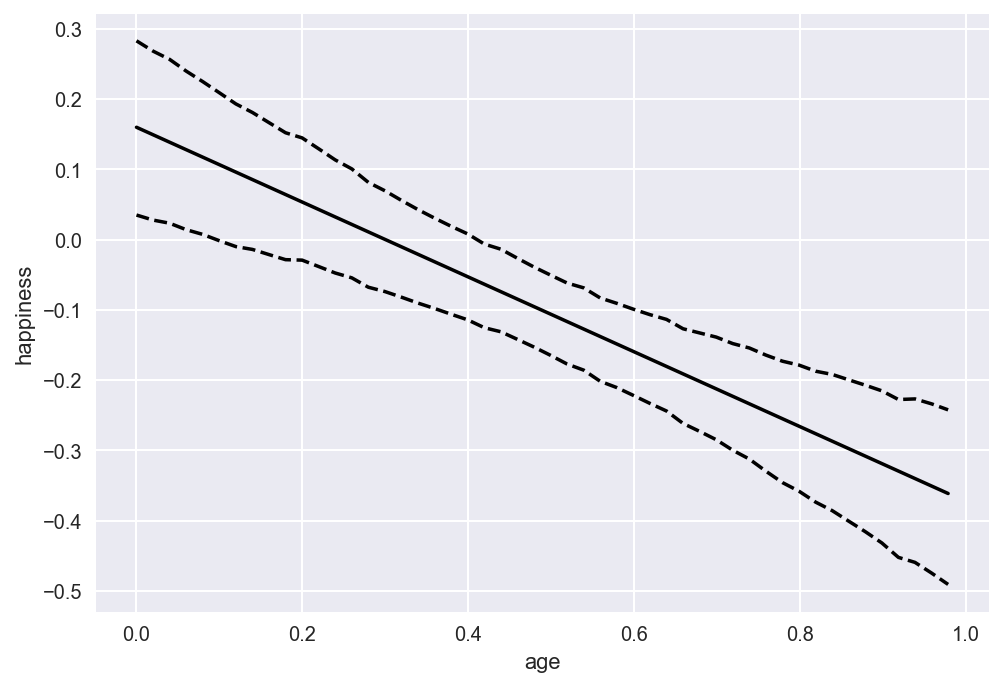

In [43]:
plot_counterfactual(df2, trace_age_happiness, 
                    variables=['age_s', 'married'], 
                    parameters=['b_a', 'b_m'],
                    intercept='a',
                   xlab='age',
                   ylab='happiness')

***

Compare this to a simple model that does not include marriage:

In [11]:
# Compare to a simple model without marriage:

with pm.Model() as age_happiness2:
    a = pm.Normal('a', 0, 1)
    b_a = pm.Normal('b_a', 0, 2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b_a * df2['age_s'])
    happiness = pm.Normal('happiness', mu, sigma, observed=df2['happiness_s'])
    
    trace_age_happiness2 = pm.sample(1000, tune=300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_a, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 3900/3900 [00:04<00:00, 917.89draws/s]
The acceptance probability does not match the target. It is 0.8912955052664757, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9384518587379802, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9334660446161556, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
print(pm.summary(trace_age_happiness2, varnames=['a', 'b_a', 'sigma']))
# pm.traceplot(trace_age_happiness2);

           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.100910  0.073506  0.001779 -0.239275  0.050823  1236.458583  0.999872
b_a    0.001614  0.131831  0.003254 -0.246465  0.261135  1255.665633  0.999566
sigma  1.154913  0.027164  0.000607  1.099159  1.203239  1815.905548  0.999502


This simpler model (correctly) does not identify an association between age and happiness.

It is possible that in the real world marriage *does* causally influence happiness, and that happiness changes over time. However, the point of this example is that you cannot draw causal inferences if you don't have a causal model. A regression itself does not provide evidence that you need to justify a causal model--instead you need evidence outside of the model (i.e., science).

### 6.3.2 The Haunted DAG

Collider bias can affect your model even when the collider is not measured. Suppose for example that we are interested in the direct influence of Parents (P) and Grandparents (G) on the educational achievements of children (C).

We may characterize this relationship with with the following DAG:

        ↗ P
      G   ↓
        ↘ C

Where G affects P, and both G and P directly influence C.

But suppose there are unmeasured influences that are common to both P and C (eg., neighbourhood) that are not shared by G. Then the DAG becomes haunted by the unobserved U:

        ↗ P ↖ 
      G   ↓   U
        ↘ C ↙


P is now a collider of G and U (i.e., a parent's educational achievement is influenced by grandparent's educational achievement and their neighbourhood). If we condition on P in our model, we will "open" the pathway between G and U, even though U was unmeasured.

In [13]:
# Here is the code for one permutation of this example:
n = 200

# These are like the slopes of a model
b_gp = 1    # Effect of G on P
b_gc = 0    # Effect of G on C (no effect) [What we are trying to estimate]
b_pc = 1    # Effect of P on C
b_u = 2    # Effect of U on P and C [unmeasureable]

# Define parameters
    # This stupid ass randint function uses an exclusive upper bound so this is [0, 1]:
u = np.random.randint(0, 2, size=n)    # For simplicity treat U as a binary (eg., bad/good neighbourhood)
g = np.random.normal(0, 1, size=n)    # G is just a random variable independent from the others
p = np.random.normal(b_gp*g + b_u*u, size=n)    # p is a function of G and U
c = np.random.normal(b_pc*p + b_gc*g + b_u*u, size=n)    # c is a function of P, G, and U.
dat = pd.DataFrame(data={'u':u, 'g':g, 'p':p, 'c':c})

In [14]:
# Now we are naive scientists making a model of C ~ G + P, but unaware of U.

with pm.Model() as m_grandparents:
    a = pm.Normal('a', 0, 1)
    b_pc = pm.Normal('b_pc', 0, 1)
    b_gc = pm.Normal('b_gc', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b_pc * dat['p'] + b_gc * dat['g'])
    children = pm.Normal('children', mu, sigma, observed=dat['c'])
    
    trace_m_grandparents = pm.sample(500, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_gc, b_pc, a]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████| 2100/2100 [00:03<00:00, 609.41draws/s]
The acceptance probability does not match the target. It is 0.9123390664118798, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9275136384256537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9167278067100912, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
pm.summary(trace_m_grandparents)[0:4]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.652079,0.136152,0.006141,0.389068,0.907488,364.460360,1.002492
b_pc,1.475240,0.068755,0.002711,1.336875,1.602936,518.363356,0.999692
b_gc,-0.471669,0.114952,0.004429,-0.711904,-0.258406,515.428165,1.000872
sigma,1.347784,0.070014,0.001814,1.203570,1.478154,1445.824232,0.999786


Our model overestimates the effect of parents. That's a normal confound as `b_pc` incorporates some of `b_u`. What is more damaging is that our model is quite confident that grandparents' educational status have a negative influence on their children's educational status.

How did this arise? By "controlling" for parents, we are stratifying the sample based on parental educational level. I.e., we are asking: *at each level of the parent's education, what is the impact of grandparent's education?*

However, by controling for parents, we are introducing an artificial selection process. Parents achieve high levels of education by being from a good neighbourhood *or* by having highly educated parents (i.e., grandparents). E.g., If we look at parents at a median educational level, we would see that *either* the grandparent is poorly educated and they are from a good neighbourhood *or* they are from a bad neighbourhood and the grandparent is well educated (this example extends to all percentiles). By controlling for parent educational level, we've selected for *bad neighourboods* as we increase in grandparent education level. Since neighbourhood causally influences the child's educational level, we see a negative association between the grandparent's education and the child's education.

***

In the figure below, parental education is denoted by the colour of the circle (white = least educated, black = most educated). With visual inspection you can see when when you look at similarly coloured circles (i.e., children with similarly educated parents), there is a negative trend between grandparent education and the child's education.


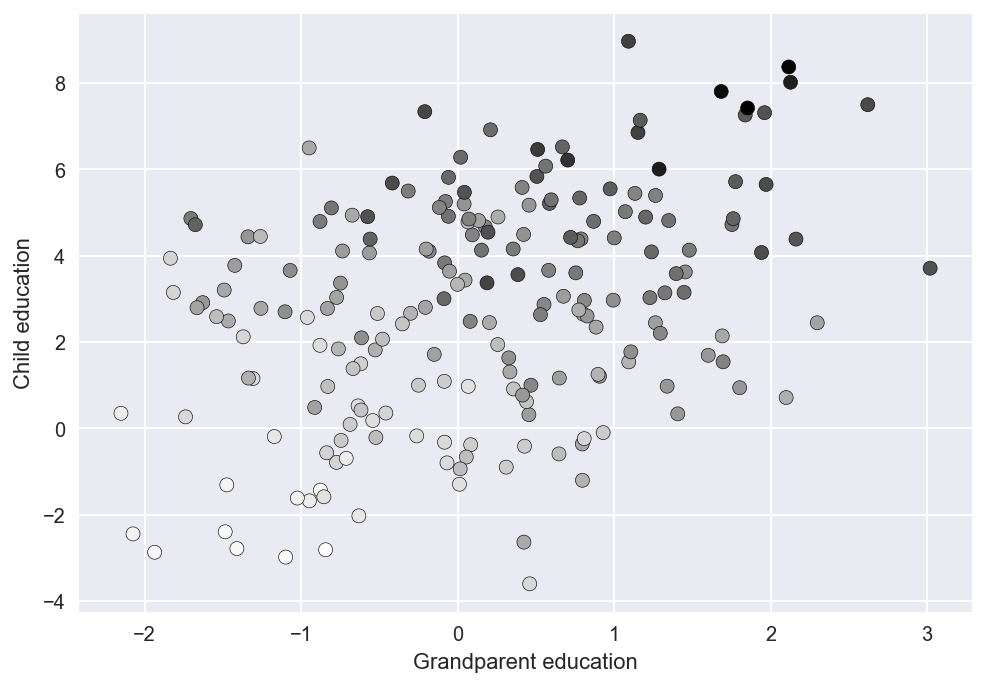

In [44]:
plt.scatter(x=dat['g'], y=dat['c'], c=dat['p'], edgecolors='black');
plt.xlabel('Grandparent education');
plt.ylabel('Child education');


This is a contrived example, where U is a binary variable with double the effect of the observed variables. However, collider bias still affects your interpretation of hte model even when the effects are smaller.


For this particular DAG, there is no way that we can make causal inference unless we can observe U. P remains a confound that we *should* control for, but doing so opens us up to collider bias from U.


***

## 6.4 Confronting Confounding

Up until now, we have seen several examples of how multiple regression can be used to deal with confounding. However, we have also seen how multiple regression can **cause** confounding--controlling for the wrong variables ruins inference. What we have seen up until now is that adding every possible covariate to a model does not improve inference. In contrast, careful selection of covariates can aid in effective inference.

#### Experimental Control for Confounding

**Confounding** can be thought of as any context in which the association between the outcome and the predictor is not the same as it would be had we experimentally assigned the pedictor.

For example, in a simple model where we look at the effect of education (E) on wages (W), the DAG may look like this:

        ↗ E
       U  ↓
        ↘ W

There are unobserved variables that might cause both E and W, such as work ethic or neighbourhood. In effect there are two "paths" by which E could connect to W. One is `E --> W` and the other is `E <-- U --> W`. As long as these two paths exist, we can't establish a definitive causal relationship between E and W. 

If we had experimentally assigned education levels, then we could be sure that U is not influencing E. Our DAG would then look like this:

          E
       U  ↓
        ↘ W
        
What we've done is "shut the back door" on the path that goes through U. Now that there is only one path that information can flow between E and W, the association between the two may actually be useful in causal inference.


#### Statistical Control for Confounding

There are also statistical ways of achieving the same result without actually manipulating E. For example, by conditioning on U in a multiple regression model. How does this work?

One way to think of how conditioning on U blocks the path `E <-- U --> W`, think of this model in complete isolation (without `E --> W`) [This is a fork].

Suppose that U is the average wealth in a region. More wealth results in better education, but also results in better paying jobs (higher wages). In this model, if you knew U, adding E to the model would do nothing to inform you of W because U encodes all of that information already. If you don't know U, then knowing E will give you more information about W than you already had.

Returning to the original DAG:

        ↗ E
       U  ↓
        ↘ W

Conditioning on U now means that any information that flowed from E to W through U is no longer informative because U already provides this information. *E and W are said to be independent, conditional on U.*

### 6.4.1 Shutting the Backdoor

Blocking all confounding paths between a predictor and an outcome is known as *shutting the **backdoor***.

**The good news**: For any given DAG, it is always possible to determine which, if any variables should be controlled for in order to leave the path of interest open. We will also know whether or not it is *actually possible* to make causal inference (i.e., close all of the backdoors).

**Some more good news**: There are only four types of DAG relationships that combine to form all possible paths: The **fork**, the **pipe**, the **collider** and the **descendant**.

**Some bad news**: In order for this to be useful we need to able to assume a certain DAG. If we can't construct a DAG then we can't do anything. If our DAG is wrong and we take it too seriously, we risk making the wrong decisions based on our model.

#### 6.4.1.1 The Four Confounds

There are only four ways that information can flow in a DAG (X is the predictor, Y is the outcome, and Z is the confound):

1. **FORK**: 

    `X <-- Z --> Y`

    This is the classic confound where a confounding variable is a common cause of both X and Y. E.g., Hot temperature may cause both increased ice cream sales and drowning deaths). We "close" the Fork by conditioning on Z.
    
2. **PIPE**:

    `X --> Z --> Y`
    
    This is the confound that is happening when we see Post-Treatment Bias. E.g., Gender may cause career choice, which may cause salary. Just like the Fork, we close the Pipe by conditioning on Z. Note, however, that we don't always *want* to close the path. *Closing* the path is what results in Post-Treatment Bias in this example.
    
3. **COLLIDER**:

    `X --> Z <-- Y`
    
    Unlike the other confounds, there is no relationship between X and Y until you condition on Z. E.g., Both age and happiness may cause marriage. If we simply looked at `happiness ~ age` we would not see a relationship. Controlling for marriage opens this path.
    
4. **DESCENDANT**:
```    
    X --> Z --> Y
          ⭣
          K
```            
    The Descendant is not exactly a confound. Controlling for a Descendant, K, is similar to controlling for the actual variable, Z, only weaker. Because K contains some information about Z, it can be used to partially close a backdoor path if Z is unobserved.
    

### 6.4.2 A DAG Example:


          A
       ⭩     ⭨
     U         C
     | ⭨     ⭩ |
     ⭣    B    ⭣
     X ------> Y
     
We are only interested in the Path from X --> Y. However, there are two other paths that connect X and Y:

1. X <-- U <-- A --> C --> Y

2. X <-- U --> B <-- C --> Y

Path 1 is a Fork. We should condition on A or C to close the path (or U, but it is unobserved).

Path 2 is a collider. We should *not* condition on B.

There is an R package for determining what variables to control for given a DAG: `dagitty` 

### 6.4.3 Backdoor Waffles

As a final example, we will return to the divorce rate example from Chapter 5. We'll make a DAG and use it to find a minimal set of covariates. We can then test our DAG and see if our evidence is consistent with our DAG.

We want to know if Waffle Houses cause divorce. Here is our DAG:

```
S ----> W
| ⭨     |
|   M   |
⭣ ⭧  ⭨  ⭣
A ----> D
```

Where `S` is whether or not a State is in the Southern US. `A` is median age at marriage. `M` is marriage rate. `W` is the number of Waffle Houses in that state. `D` is divorce rate.

There are four causal pathways in this model:

`S --> W --> D` (Southern states have more Waffle Houses, which cause divorce)

`S --> A --> D` (Southern states have lower median age at marriage, which causes divorce)

`S --> M --> D` (Southern states have higher marriage rates, which cause divorce)

`S --> A --> M --> D` (Souther states have lower median age at marriage, which leads to higher marriage rates, which causes divorce)

In our model, we want to know if Waffle Houses cause divorce (`W --> D`). However, Waffle Houses are caused by "Southernness". As we've described in the DAG, we believe that there are other pathways by which Southerness can cause increased divorce rates. There are three backdoors in this DAG:

`W <-- S --> M --> D`

`W <-- S --> A --> D`

`W <-- S --> A --> M --> D`

Here, we can control for either S, or A and M.

***

### DAGs are not enough

DAGs are not the endpoint when it comes to making causal inference. Once you have a dynamical model of your system you don't need a DAG. Many dynamical systems cannot be usefully represented by DAGs because they have complex behaviour that is sensitive to initial conditions.

However, this is not an argument against DAGs. They are still a useful tool when such a model does not exist.
***

## 6.6 Practice

**6H1.** Use the Wafe House data, `data(WaffleDivorce)`, to find the total causal inﬂuence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

In [17]:
d_divorce = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

#Standardize some variables
d_divorce['WaffleHouses_s'] = (d_divorce['WaffleHouses'] - d_divorce['WaffleHouses'].mean()) / d_divorce['WaffleHouses'].std()
d_divorce['Divorce_s'] = (d_divorce['Divorce'] - d_divorce['Divorce'].mean()) / d_divorce['Divorce'].std()
d_divorce['MedianAgeMarriage_s'] = (d_divorce['MedianAgeMarriage'] - d_divorce['MedianAgeMarriage'].mean()) / d_divorce['MedianAgeMarriage'].std()
d_divorce['Marriage_s'] = (d_divorce['Marriage'] - d_divorce['Marriage'].mean()) / d_divorce['Marriage'].std()

d_divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,WaffleHouses_s,Divorce_s,MedianAgeMarriage_s,Marriage_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,1.454029,1.654205,-0.606290,0.022644
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.491567,1.544364,-0.686699,1.549802
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.217968,0.610716,-0.204241,0.048974
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,0.131632,2.093569,-1.410387,1.655123
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,-0.491567,-0.927058,0.599857,-0.266989


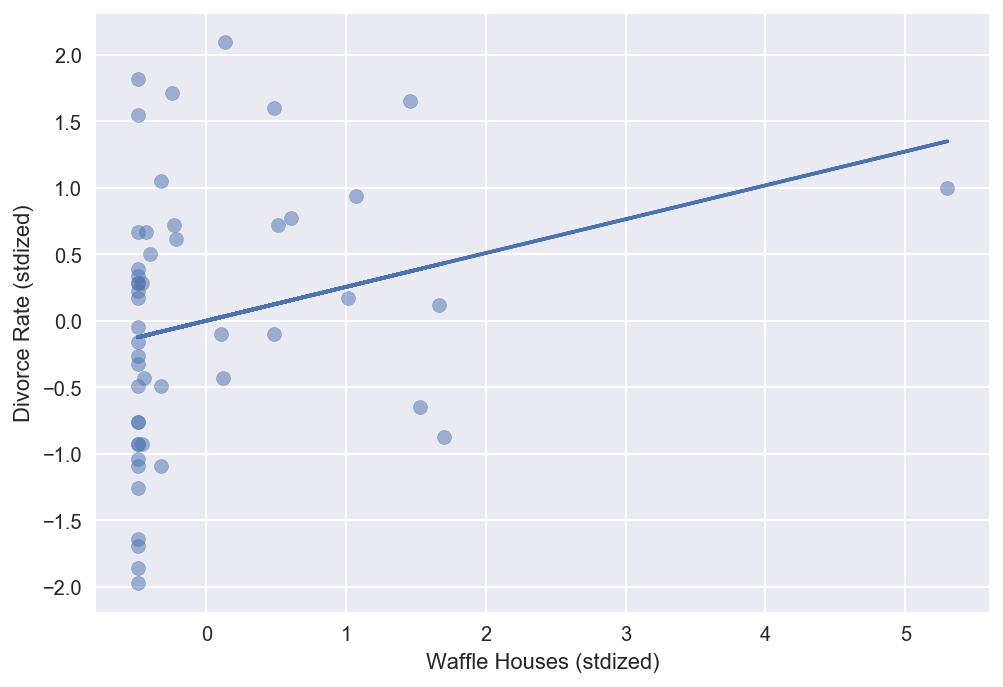

In [45]:
# A simple plot of Divorce ~ Waffle Houses. There is an association apparent.
b, m = np.polynomial.polynomial.polyfit(d_divorce['WaffleHouses_s'], d_divorce['Divorce_s'], deg=1)

plt.scatter(d_divorce['WaffleHouses_s'], d_divorce['Divorce_s'], alpha = 0.5);
plt.plot(d_divorce['WaffleHouses_s'], b + m * d_divorce['WaffleHouses_s'], '-');
plt.xlabel('Waffle Houses (stdized)');
plt.ylabel('Divorce Rate (stdized)');

In [19]:
# Make a model that controls for "Southern State"

with pm.Model() as m_6h1:
    a = pm.Normal('a', -2, 3)
    b_S = pm.Normal('b_S', 0, 2)
    b_W = pm.Normal('b_W', 0, 2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South'] + b_W * d_divorce['WaffleHouses_s'])
    divorce_s = pm.Normal('divorce_s', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h1 = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_W, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:04<00:00, 1115.48draws/s]


         mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a   -0.196690  0.178139  0.003735 -0.529291  0.168561  1618.057740  1.001419
b_S  0.696226  0.417750  0.010203 -0.123148  1.546618  1471.534003  1.001655
b_W  0.038479  0.192841  0.004655 -0.339450  0.422704  1746.923717  1.000025


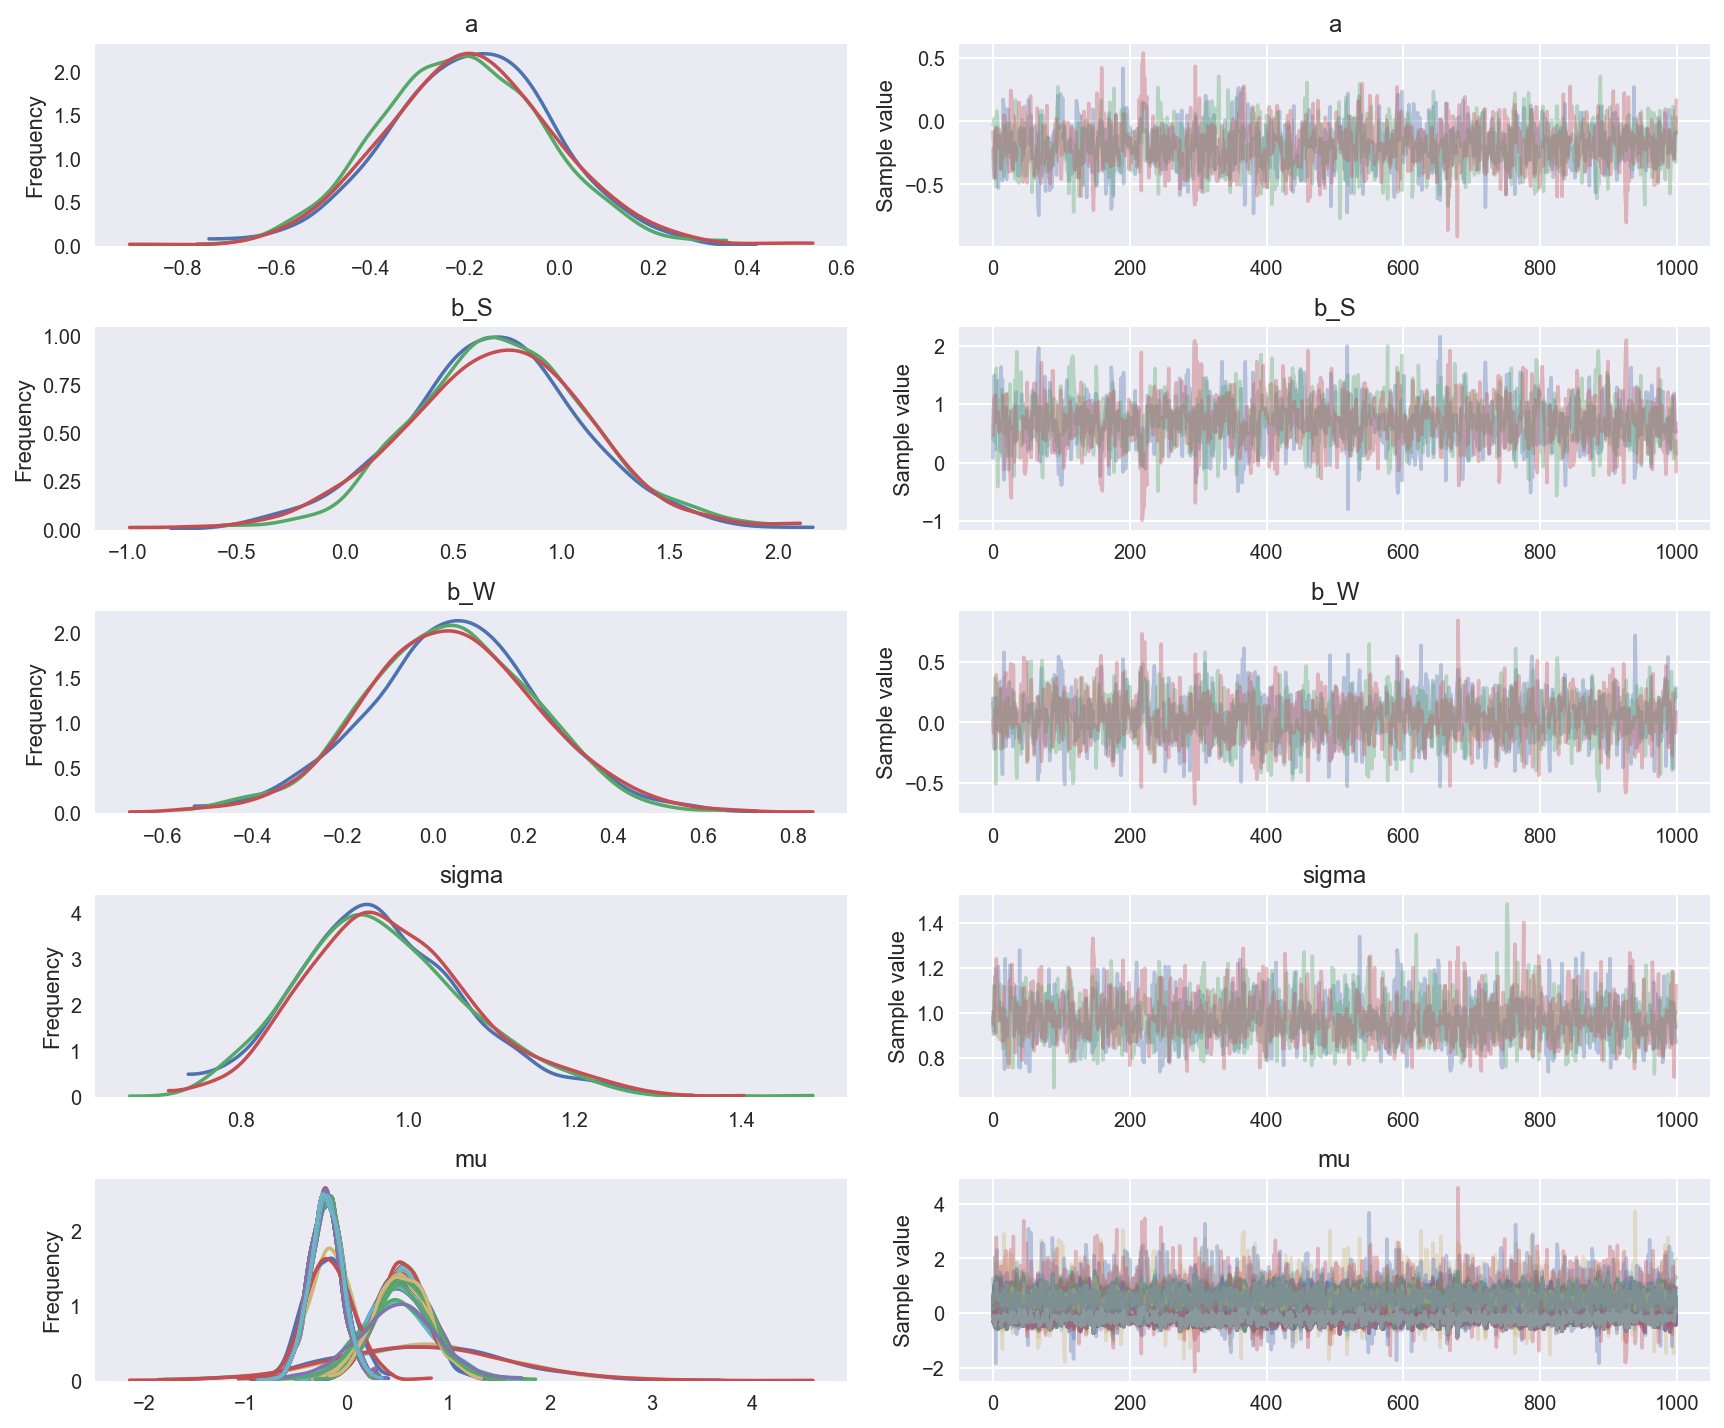

In [46]:
print(pm.summary(t_m_6h1)[0:3])
pm.traceplot(t_m_6h1);

In the scatter plot above we saw an association between `Waffle Houses` and `Divorce`. However, the contribution of `Waffle Houses` independent of `Southerness` is close to zero. In contrast, a large portion of the probability density of `b_S` falls above zero, indicating that `Southerness` may contribute to divorce independent of `Waffled Houses`.

***

#### 6H2

Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data.

There are four causal pathways in this model:

1. `S --> W --> D`

2. `S --> A --> D`

3. `S --> M --> D`

4. `S --> A --> M --> D`

We already tested the first. We saw that `S --> W`, but `W -/-> D`.

We'll revise the DAG as follows:


```
S ----> W
| ⭨     
|   M   
⭣ ⭧  ⭨ 
A ----> D
```

We will test the pathways 2-4 in the code blocks below.

***

##### 6H2A  -- Pathway 2: S --> A --> D

First: A model of `Divorce ~ Median Age at Marriage`

In [21]:
# 2:

# Model of just Age and Divorce
with pm.Model() as m_6h2a:
    a = pm.Normal('a', -2, 2)
    b_A = pm.Normal('b_A', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_A * d_divorce['MedianAgeMarriage_s'])
    divorce_s = pm.Normal('divorce_s', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h2a = pm.sample(1000, tune=500)

print(pm.summary(t_m_6h2a)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_A, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1443.47draws/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.007023  0.114498  0.002161 -0.219857  0.223082  2929.455315  0.999560
b_A   -0.593321  0.118545  0.002002 -0.817893 -0.365321  4377.934321  0.999573
sigma  0.813612  0.081797  0.001283  0.661107  0.974055  3653.663354  0.999500


In [22]:
# Model of just South and Divorce
with pm.Model() as m_6h2b:
    a = pm.Normal('a', -2, 2)
    b_S = pm.Normal('b_S', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South'])
    divorce_s = pm.Normal('divorce_s', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h2b = pm.sample(1000, tune=500)

print(pm.summary(t_m_6h2b)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1340.02draws/s]
The acceptance probability does not match the target. It is 0.8808712986848758, but should be close to 0.8. Try to increase the number of tuning steps.


           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.220028  0.158225  0.003686 -0.522467  0.090177  2017.269414  0.999805
b_S    0.753188  0.303448  0.006670  0.189913  1.365928  1860.011655  0.999937
sigma  0.952980  0.098881  0.002137  0.765107  1.136413  2317.978593  1.000500


***

Both variables are associated with Divorce in bivariate regressions. These are consistent with our DAG pathways:

`A --> D`

`S --> A --> D`

However, they do not rule out:

`A --> S --> D`

`A _||_ S --> D` (A --> D independent of S)

To test these, I will do two new models: `D ~ A + S` and `A ~ S`

In [23]:
# D ~ A + S
with pm.Model() as m_6h2c:
    a = pm.Normal('a', -2, 2)
    b_S = pm.Normal('b_S', 0, 2)
    b_A = pm.Normal('b_A', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South'] + b_A * d_divorce['MedianAgeMarriage_s'])
    divorce_s = pm.Normal('divorce_s', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h2c = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2c)[0:3])


# A ~ S
with pm.Model() as m_6h2d:
    a = pm.Normal('a', -2, 2)
    b_S = pm.Normal('b_S', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South'])
    age_s = pm.Normal('age_s', mu, sigma, observed=d_divorce['MedianAgeMarriage_s'])
    
    t_m_6h2d = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2d)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_A, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1183.69draws/s]


         mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a   -0.136062  0.134809  0.002892 -0.380360  0.142877  2033.427168  0.999649
b_S  0.462801  0.258708  0.005773 -0.025922  0.982679  2429.329444  1.000023
b_A -0.547248  0.116669  0.002289 -0.775707 -0.324773  2816.504284  1.000095


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1333.91draws/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a      0.134393  0.162450  0.003497 -0.169679  0.464877  1849.544864  1.000237
b_S   -0.518301  0.299314  0.006722 -1.111323  0.065149  1950.100478  0.999620
sigma  0.981928  0.101885  0.002294  0.795111  1.187111  1977.684599  0.999743


***

`Median Age at Marriage` is negatively associated with `Divorce`, largely independent of `Southerness`. There is a small decrease in the magnitude of the effect. However, `b_S` has decreased much more, suggesting that `Age` occurs post-`South`. Still, `b_S` is mostly positive, suggesting that S may have an effect on D independent of `Age` (ie., via W or M or another pathway).

It may be slightly unncessary now, but we have also checked that `Age` is associated with `South` and determined that it is.

These models do not exclude the possibility that some other variable exists between `Age` and `Divorce` or `South` and `Age` (`S (--> ...) --> A (--> ...) --> D`).

***

##### 6H2A -- Pathway 3: S --> M --> D

This would be solved the same way as above, except we already know that S is associated with D so we can leave this one out.

In [24]:
# 2:

# Model of just Marriange and Divorce

with pm.Model() as m_6h2_2a:
    a = pm.Normal('a', -2, 2)
    b_M = pm.Normal('b_M', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_M * d_divorce['Marriage_s'])
    divorce_s = pm.Normal('divorce_s', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h2_2a = pm.sample(1000, tune=500)

print(pm.summary(t_m_6h2_2a)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_M, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1436.84draws/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.007261  0.131564  0.002044 -0.275917  0.231584  3714.854576  1.000025
b_M    0.371290  0.134881  0.002150  0.117774  0.649157  3542.183050  1.000163
sigma  0.941258  0.094523  0.001704  0.752941  1.110631  3312.250540  1.001133


In [25]:

# D ~ M + S
with pm.Model() as m_6h2_2b:
    a = pm.Normal('a', -2, 2)
    b_S = pm.Normal('b_S', 0, 2)
    b_M = pm.Normal('b_M', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South'] + b_M * d_divorce['Marriage_s'])
    divorce_s = pm.Normal('divorce_s', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h2_2b = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2_2b)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_M, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1203.83draws/s]


         mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a   -0.201045  0.148702  0.003237 -0.496939  0.087561  1996.365836  0.999681
b_S  0.695177  0.278407  0.005928  0.202636  1.246666  2027.692379  0.999649
b_M  0.345711  0.127621  0.002240  0.113041  0.611168  2956.982488  0.999576


In [26]:
# M ~ S
with pm.Model() as m_6h2_2c:
    a = pm.Normal('a', -2, 2)
    b_S = pm.Normal('b_S', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South'])
    marriage_s = pm.Normal('marriage_s', mu, sigma, observed=d_divorce['Marriage_s'])
    
    t_m_6h2_2c = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2_2c)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1366.12draws/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.059521  0.167628  0.003476 -0.395543  0.265392  1913.448591  1.000610
b_S    0.186157  0.310778  0.007459 -0.444924  0.754796  1701.048431  1.000066
sigma  1.011876  0.103479  0.001667  0.837774  1.231802  3222.803646  1.000249


***

1. `Marriage rate` is associated with Divorce, consistent with the DAG.

2. `Marriage rate` also appears to associated with Divorce, largely independent of `South` as the magnitude of `b_M` only decreases slightly. However, `b_S` also only decreases slightly, suggesting that our DAG pathway `S --> M` may not be true (or it may just be very weak).

3. `South` is only weakly associated with `Marriage rate`. The majority of the probability density falls above 0, but a considerable portion is negative. It is not clear that `S --> M`. The following DAG pathways are also possible:

    `M --> D <-- S`

    `S --> D` and `M --> D` and (`S --> ... --> M` or `M --> ... --> S`)
   
    i.e., there may be some variables between S and M that make their relationship much weaker whereas both have *more* direct pathways to D. As well, we don't know which one comes first if they are causally related.

To test if Divorce is a collider of M and S I will run a model of `S ~ M + D`:

In [27]:
# Test if Divorce is a Collider of Marriage Rate and South
# S ~ M + D
with pm.Model() as m_6h2_2d:
    a = pm.Normal('a', -2, 2)
    b_S = pm.Normal('b_S', 0, 2)
    b_D = pm.Normal('b_D', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South'] + b_D * d_divorce['Divorce_s'])
    marriage_s = pm.Normal('marriage_s', mu, sigma, observed=d_divorce['Marriage_s'])
    
    t_m_6h2_2d = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2_2d)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_D, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1196.15draws/s]


         mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a    0.017519  0.159019  0.003131 -0.288408  0.329477  2047.857836  0.999664
b_S -0.099463  0.318532  0.007083 -0.695402  0.559459  1971.644441  0.999508
b_D  0.391280  0.151222  0.003349  0.095641  0.690623  2200.263522  0.999899


***

After including `Divorce` in the model, the relationship between `Marriage rate ~ South` went from weakly positive to weakly negative. This suggests that `Divorce` is a collider of `Marriage rate` and `South`.

We may revise our DAG as follows:

```
S --> W
⭣     ⭣
A --> D <-- M 
```

However, it is still possible that S has a direct path to D, or that M does not have a direct path to D.

***

##### 6H2A -- Pathway 4: S --> A --> M --> D

In the previous part, we found that it is unlikely that there is a direct path connected `S --> M --> D`. It is possible that S connects to M through A.

In an earlier part of this question, we established that `S --> A --> (... -->) D`. We want to know if the "..." is M.

To do this I will test:

`M --> D`

`A --> M --> D`

In [28]:
# Initial test to see if M is associated with D in a bivariate regression
# D ~ M
with pm.Model() as m_6h2_3a:
    a = pm.Normal('a', -2, 2)
    b_M = pm.Normal('b_M', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_M * d_divorce['Marriage_s'])
    divorce = pm.Normal('divorce', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h2_3a = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2_3a)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_M, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1482.45draws/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.008023  0.134210  0.002391 -0.285991  0.240149  3539.234207  1.000064
b_M    0.371812  0.134665  0.002090  0.117420  0.639251  3615.783171  1.000184
sigma  0.942219  0.093537  0.001886  0.769945  1.134088  2857.632710  1.000467


In [29]:
# Test to see the effect of M on D, conditional on A. If M is a post-treatment effect of A we expct the magnitude
# of b_M to decrease less than b_A (compare to m_62ha [~  -0.6]).
# D ~ M + A
with pm.Model() as m_6h2_3b:
    a = pm.Normal('a', -2, 2)
    b_M = pm.Normal('b_M', 0, 2)
    b_A = pm.Normal('b_A', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_M * d_divorce['Marriage_s']) + b_A * d_divorce['MedianAgeMarriage_s']
    divorce = pm.Normal('divorce', mu, sigma, observed=d_divorce['Divorce_s'])
    
    t_m_6h2_3b = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2_3b)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_A, b_M, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1184.49draws/s]


         mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a   -0.006528  0.116457  0.001987 -0.243299  0.218252  2694.390160  0.999667
b_M -0.113096  0.169720  0.003756 -0.427025  0.241937  2135.790814  0.999536
b_A -0.676063  0.169239  0.003957 -0.991123 -0.324251  2116.231148  1.000226


1. In the first regression we see that marriage rate is associated with divorce.

2. In the second regression we see that marriage rate is probably not a "post"-`age` effect. Adding marriage to the model turns `b_M` slightly negative, with a large proportion of the probablility density overlapping on both sides of 0. In contrast, the magnitude of b_A is unchanged, or slightly greater in magnitude compared to the bivariate `D ~ A` model (m_62ha).

Adding Marriage to the model adds no additional information if we already know Median Age at Marriage. Is it possible that Age is a post-treatment effect of Marriage rate? If this is the case, we could revise our DAG as follows:

```
      S --> W
      ⭣     ⭣
M --> A --> D 
```

We previously saw that M and S were only weakly associated. If this DAG were true, we would expect that Age is a collider of Marriage Rate and South. I will run another set of regressions to test this:

`M ~ A` to show that M --> A (in the previous section we showed it was unlikely that A --> M --> D)

`M ~ S + A` to show that M is associated with S if we control for A.

In [30]:
# M ~ A
with pm.Model() as m_6h2_3c:
    a = pm.Normal('a', -2, 2)
    b_A = pm.Normal('b_A', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_A * d_divorce['MedianAgeMarriage_s'])
    marriage = pm.Normal('marriage', mu, sigma, observed=d_divorce['Marriage_s'])
    
    t_m_6h2_3c = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2_3c)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_A, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1470.98draws/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a     -0.004990  0.103223  0.001417 -0.216053  0.192277  4037.939953  0.999937
b_A   -0.717066  0.100831  0.001694 -0.909855 -0.512617  3363.090620  0.999811
sigma  0.709314  0.072674  0.001222  0.571093  0.847459  3813.708534  0.999735


In [31]:
# M ~ S + A
with pm.Model() as m_6h2_3d:
    a = pm.Normal('a', -2, 2)
    b_S = pm.Normal('b_S', 0, 2)
    b_A = pm.Normal('b_A', 0, 2)
    sigma = pm.Exponential('sigma', 2)
    mu = pm.Deterministic('mu', a + b_S * d_divorce['South']) + b_A * d_divorce['MedianAgeMarriage_s']
    marriage = pm.Normal('marriage', mu, sigma, observed=d_divorce['Marriage_s'])
    
    t_m_6h2_3d = pm.sample(1000, tune=500)
    
print(pm.summary(t_m_6h2_3d)[0:3])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, b_A, b_S, a]
Sampling 3 chains: 100%|██████████████████████████████████████████████████████| 4500/4500 [00:03<00:00, 1304.78draws/s]


         mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
a    0.054295  0.121490  0.002779 -0.175994   0.29558  2022.768041  1.000012
b_S -0.217818  0.242501  0.005893 -0.670191   0.27464  1740.047759  1.000383
b_A -0.745457  0.109957  0.002127 -0.957261  -0.52986  2317.547964  0.999581


In the bivariate regression model of `M ~ S` (m_6h2_2c), `b_S` was b_S 0.19 with a 95% HDPI of -0.44 to 0.80.

After adding Age (`M ~ S + A`) `b_S` became -0.22 with a 95% HDPI of -0.68 to 0.20. This suggests that Median Age at Marriage is a collider of South and Marriage Rate. It also supports the DAG below, as Age seemed to be a "stronger" collider of South and Marriage rate than Divorce.


```
      S --> W
      ⭣
M --> A --> D 
```

This model does not rule out the possibility of unobserved variables between each of the arrows.

In [32]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

C:\Users\alexa\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  


This notebook was createad on a computer AMD64 running   and using:
Python 3.7.1
IPython 7.2.0
PyMC3 3.6
NumPy 1.15.4
Pandas 0.23.4
SciPy 1.1.0
Matplotlib 3.0.2

